In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import requests

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define the file path in your Google Drive
file_path = "/content/drive/MyDrive/Differential PCA, rough volatility models and financial time series/Data/Data_used/acfinance.txt"

# Initialize a list to store the closing prices
close_prices = []

# Open and read the file
with open(file_path, "r") as file:
    for line in file:
        # Convert each line to a float and append it to the list
        close_prices.append(float(line.strip()))

# Display the extracted closing prices
print("Closing Prices:", close_prices)

Closing Prices: [34.269991, 33.950011, 33.639991, 33.24999, 32.97999, 33.129991, 32.849999, 33.230009, 33.759991, 33.36999, 32.180011, 32.910001, 33.050011, 32.949989, 32.75001, 33.150001, 33.21999, 33.02001, 32.570011, 32.919989, 33.699989, 33.84999, 34.13001, 34.419989, 34.89, 35.169989, 35.300011, 35.319989, 36.009991, 35.450011, 35.78001, 35.300011, 35.70999, 35.90001, 35.199989, 35.330011, 35.939999, 36.09999, 36.200011, 36.99, 37.26, 36.569999, 37.199999, 37.349999, 37.52001, 36.63, 36.680011, 37.329989, 37.410001, 37.430011, 37.560001, 37.700011, 37.52001, 37.23999, 36.87, 36.29001, 35.300011, 35.300011, 34.98999, 31.199999, 30.89001, 30.930001, 30.590009, 29.00001, 29.670001, 29.849999, 28.79001, 28.71999, 28.550011, 29.210009, 29.570011, 29.579999, 30.429989, 31.059989, 31.929989, 31.709999, 31.449989, 31.730009, 32.169989, 32.39001, 32.51001, 32.889991, 32.73, 32.799989, 32.66001, 32.919989, 32.52, 32.400001, 32.25, 32.280001, 32.10999, 31.820011, 31.269991, 31.340009, 31.449

In [4]:
close_prices = np.asarray(close_prices)

close_prices = (close_prices - np.mean(close_prices)) / np.std(close_prices)

Time series length: 800
Testing up to 10 dimensions with delay 1.

Embedding dimension: 1
Number of embedding vectors (M): 799
Nearest distances (sample): [0.00011379 0.00122024 0.00048687 0.00124446 0.00048723]
Nearest neighbor indices (sample): [775 503 370 573 191]
False Nearest Neighbors (%) at dimension 1: 98.1226533166458

Embedding dimension: 2
Number of embedding vectors (M): 798
Nearest distances (sample): [0.02279443 0.03041626 0.02028632 0.01599298 0.0343783 ]
Nearest neighbor indices (sample): [187 601 224 279 447]
False Nearest Neighbors (%) at dimension 2: 69.17293233082707

Embedding dimension: 3
Number of embedding vectors (M): 797
Nearest distances (sample): [0.05158381 0.10311323 0.04732615 0.06639492 0.09601231]
Nearest neighbor indices (sample): [238  75 734 222 733]
False Nearest Neighbors (%) at dimension 3: 18.444165621079048

Embedding dimension: 4
Number of embedding vectors (M): 796
Nearest distances (sample): [0.17112876 0.20459173 0.15968125 0.14681649 0.172

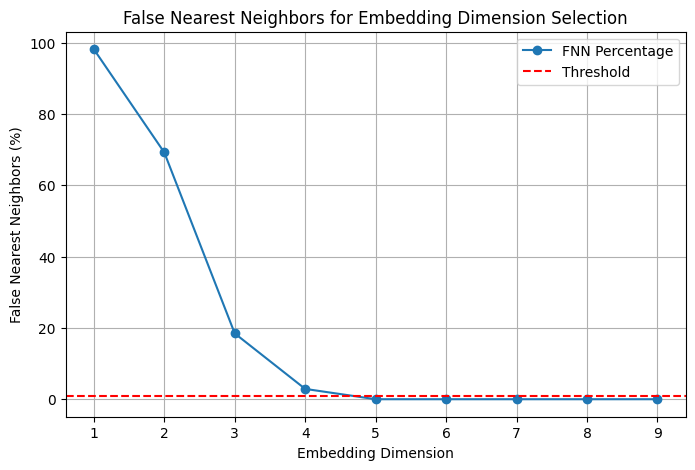

Optimal embedding dimension: 5
FNN Percentages: [98.1226533166458, 69.17293233082707, 18.444165621079048, 2.8894472361809047, 0.0, 0.0, 0.0, 0.0, 0.0]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def false_nearest_neighbors(time_series, max_dim=10, tau=1, rtol=10, atol=2):
    """
    Compute False Nearest Neighbors (FNN) to determine the optimal embedding dimension.

    Parameters:
    - time_series: 1D array of time series data.
    - max_dim: Maximum embedding dimension to test.
    - tau: Time delay.
    - rtol: Relative tolerance for false neighbor determination.
    - atol: Absolute tolerance for false neighbor determination.

    Returns:
    - optimal_dim: The estimated optimal embedding dimension.
    - fnn_percentages: List of FNN percentages for each embedding dimension.
    """
    data = np.asarray(time_series)
    N = len(data)
    fnn_percentages = []

    print(f"Time series length: {N}")
    print(f"Testing up to {max_dim} dimensions with delay {tau}.")

    for d in range(1, max_dim + 1):
        M = N - d * tau
        if M <= 0:
            print(f"Stopping at dimension {d}. Not enough points left for embedding.")
            break

        # Debug: Report embedding process
        print(f"\nEmbedding dimension: {d}")
        print(f"Number of embedding vectors (M): {M}")

        # Create embedded vectors
        try:
            embedded = np.array([data[i:i + d * tau:tau] for i in range(M)])
        except Exception as e:
            print(f"Error during embedding at dimension {d}: {e}")
            break

        # Use KDTree for efficient nearest-neighbor search
        try:
            tree = KDTree(embedded)
            distances, indices = tree.query(embedded, k=2)
        except Exception as e:
            print(f"Error using KDTree at dimension {d}: {e}")
            break

        # Distance to nearest neighbor (exclude self at distance 0)
        nearest_dist = distances[:, 1]
        nearest_idx = indices[:, 1]

        # Debug: Check KDTree results
        print(f"Nearest distances (sample): {nearest_dist[:5]}")
        print(f"Nearest neighbor indices (sample): {nearest_idx[:5]}")

        # Calculate distances in dimension d+1
        if d + 1 > max_dim:
            print(f"Skipping d+1 calculation for dimension {d}. Exceeds max_dim.")
            break
        try:
            next_values = data[d * tau : d * tau + M]
            neighbor_next_indices = nearest_idx + d * tau
            valid_indices = neighbor_next_indices < len(data)
            dist_dplus1 = np.abs(next_values[valid_indices] - data[neighbor_next_indices[valid_indices]])
        except Exception as e:
            print(f"Error during calculation of distances in dimension d+1: {e}")
            break

        # Determine false neighbors
        try:
            R = np.sqrt(np.sum(embedded ** 2, axis=1))[valid_indices]
            nearest_dist_valid = nearest_dist[valid_indices]
            false_neighbors = ((dist_dplus1 / nearest_dist_valid) > rtol) | ((dist_dplus1 / R) > atol)
        except Exception as e:
            print(f"Error during false neighbor determination: {e}")
            break

        fnn_percentage = np.sum(false_neighbors) / len(false_neighbors) * 100
        fnn_percentages.append(fnn_percentage)

        # Debug: Report FNN results
        print(f"False Nearest Neighbors (%) at dimension {d}: {fnn_percentage}")

    # Plot results
    try:
        dims = list(range(1, len(fnn_percentages) + 1))
        plt.figure(figsize=(8, 5))
        plt.plot(dims, fnn_percentages, 'o-', label='FNN Percentage')
        plt.axhline(1.0, color='r', linestyle='--', label='Threshold')
        plt.xlabel('Embedding Dimension')
        plt.ylabel('False Nearest Neighbors (%)')
        plt.title('False Nearest Neighbors for Embedding Dimension Selection')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Error during plotting: {e}")

    # Optimal dimension based on threshold
    threshold = 0.1  # Adjust as necessary
    optimal_dim = max_dim
    for i, fnn in enumerate(fnn_percentages):
        if fnn < threshold:
            optimal_dim = dims[i]
            break

    # Debug: Final results
    print(f"Optimal embedding dimension: {optimal_dim}")
    print(f"FNN Percentages: {fnn_percentages}")

    return optimal_dim, fnn_percentages

# Example usage
time_series = np.random.random(800)  # Replace with your data
optimal_dim, fnn_percentages = false_nearest_neighbors(time_series)